<h1>House prices - ETL</h1>

<h2>Install and import libraries</h2>

In [1]:
#pip install scikit-learn

In [2]:
#pip install seaborn

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import copy

import LibrairiePerso_v4_8 as ownLibrary
import seaborn as sns 

import importlib

In [4]:
import os
cwd = os.getcwd()

dataset = pd.read_csv(cwd + "\\work.csv", sep=",")

len(dataset)

1460

In [5]:
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

## Split Train/Test

In [6]:
exp = list(dataset.columns.values)
exp.remove('SalePrice')
X = dataset[exp]
y = dataset['SalePrice']

X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.3 , 
                            random_state= 100 )

In [7]:
dataset = X_test
y = y_test
#y = dataset['SalePrice']

# Replacements

## Replacements for continuous features

In [8]:
X_train_MasVnrArea_medians_by_Neighborhood = pd.DataFrame( {'MasVnrArea': {'Blmngtn': 17.0, 'Blueste': 0.0, 'BrDale': 283.0, 'BrkSide': 0.0, 'ClearCr': 0.0, 'CollgCr': 72.0, 'Crawfor': 0.0, 'Edwards': 0.0, 'Gilbert': 0.0, 'IDOTRR': 0.0, 'MeadowV': 0.0, 'Mitchel': 0.0, 'NAmes': 0.0, 'NPkVill': 0.0, 'NWAmes': 176.5, 'NoRidge': 348.0, 'NridgHt': 283.0, 'OldTown': 0.0, 'SWISU': 0.0, 'Sawyer': 0.0, 'SawyerW': 0.0, 'Somerst': 60.0, 'StoneBr': 0.0, 'Timber': 48.0, 'Veenker': 0.0}} )
X_train_LotFrontage_medians_by_Neighborhood = pd.DataFrame( {'LotFrontage': {'Blmngtn': 43.0, 'Blueste': 24.0, 'BrDale': 21.0, 'BrkSide': 51.0, 'ClearCr': 80.0, 'CollgCr': 69.0, 'Crawfor': 75.0, 'Edwards': 66.0, 'Gilbert': 62.5, 'IDOTRR': 60.0, 'MeadowV': 21.0, 'Mitchel': 70.0, 'NAmes': 74.0, 'NPkVill': 24.0, 'NWAmes': 80.0, 'NoRidge': 92.0, 'NridgHt': 85.0, 'OldTown': 60.0, 'SWISU': 60.0, 'Sawyer': 71.5, 'SawyerW': 68.5, 'Somerst': 75.0, 'StoneBr': 42.5, 'Timber': 85.0, 'Veenker': 68.0}} )

<p>
There are several NAN values in the data, for the features <strong>MasVnrArea</strong> and <strong>LotFrontage</strong>.<br>
We pick the median values for these features in X_train, for each Neighborhood.<br>
Then we put these values in X_train, X_test and submission according to the Neighborhood observed.
</p>

In [9]:
ownLibrary.replaceByGroupMedian(dataset, X_train_MasVnrArea_medians_by_Neighborhood, "MasVnrArea", "Neighborhood")
ownLibrary.replaceByGroupMedian(dataset, X_train_LotFrontage_medians_by_Neighborhood, "LotFrontage", "Neighborhood")

<p>
    Here, we simply replace the NAN values by 0. <br>
    Indeed, a NAN value means no garage or no basement for theses features
</p>

In [10]:
for col in ('GarageYrBlt','GarageArea', 'GarageCars'):
    dataset.loc[:, col] = dataset[col].fillna(0)       
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'):
    dataset.loc[:, col] = dataset[col].fillna(0)
for col in ('BsmtFullBath', 'BsmtHalfBath'):
    dataset.loc[:, col] = dataset[col].fillna(0)

## Replacements for categorical features

In [11]:
dataset.Alley.fillna("eNA", inplace = True)
dataset.BsmtCond.fillna("eNA", inplace = True)
dataset.BsmtQual.fillna("eNA", inplace = True)
dataset.BsmtExposure.fillna("eNA", inplace = True)
dataset.BsmtFinType1.fillna("eNA", inplace = True)
dataset.BsmtFinType2.fillna("eNA", inplace = True)
dataset.FireplaceQu.fillna("eNA", inplace = True)
dataset.GarageType.fillna("eNA", inplace = True)
dataset.GarageFinish.fillna("eNA", inplace = True)
dataset.GarageQual.fillna("eNA", inplace = True)
dataset.GarageCond.fillna("eNA", inplace = True)
dataset.Fence.fillna("eNA", inplace = True)
dataset.MiscFeature.fillna("eNA", inplace = True)
dataset.PoolQC.fillna("eNa", inplace = True)

<p>
NA is a missing value for these categorical features.<br>
We replace each NAN value by the most occuring value
</p>

In [12]:
dataset['MasVnrType'].fillna('None', inplace = True)
dataset['Functional'].fillna('Typ', inplace = True)
dataset['MSZoning'].fillna('RL', inplace = True)
dataset['Electrical'].fillna('SBrkr', inplace = True)
dataset['KitchenQual'].fillna('TA', inplace = True)
dataset['Exterior1st'].fillna('VinylSd', inplace = True)
dataset['Exterior2nd'].fillna('VinylSd', inplace = True)
dataset['SaleType'].fillna('WD', inplace = True)
dataset['Utilities'].fillna('AllPub', inplace = True)
    

# Creation of new features

In [13]:
dataset.loc[:, 'GarageCars'] = dataset['GarageCars'].astype(int)
dataset.loc[:, 'BsmtFullBath'] = dataset['BsmtFullBath'].astype(int)
dataset.loc[:, 'BsmtHalfBath'] = dataset['BsmtHalfBath'].astype(int)

<p>
We create new features.<br>
For example, doing the addition of :<br>
    <ul>
        <li>The first floor surface</li>
        <li>The second floor surface</li>
        <li>The basement surface</li>
    </ul>
Will result in a new feature that we call the "Total Surface of the house" : TotalSF.<br>

We also create some bolean features indicating if the house has : a pool / garage / fireplace / basement / 2nd floor
</p>

In [14]:
dataset.loc[:, 'YrBltAndRemod']=dataset['YearBuilt']+dataset['YearRemodAdd']
dataset.loc[:, 'TotalSF']=dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

dataset.loc[:, 'Total_sqr_footage'] = (dataset['BsmtFinSF1'] + dataset['BsmtFinSF2'] +
                               dataset['1stFlrSF'] + dataset['2ndFlrSF'])

dataset.loc[:, 'Total_Bathrooms'] = (dataset['FullBath'] + (0.5 * dataset['HalfBath']) +
                             dataset['BsmtFullBath'] + (0.5 * dataset['BsmtHalfBath']))

dataset.loc[:, 'Total_porch_sf'] = (dataset['OpenPorchSF'] + dataset['3SsnPorch'] +
                            dataset['EnclosedPorch'] + dataset['ScreenPorch'] +
                            dataset['WoodDeckSF'])

dataset.loc[:, 'haspool'] = dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
dataset.loc[:, 'has2ndfloor'] = dataset['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
dataset.loc[:, 'hasgarage'] = dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
dataset.loc[:, 'hasbsmt'] = dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
dataset.loc[:, 'hasfireplace'] = dataset['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Delete not used features

<p>
We delete some features which have not enough occuring
</p>

In [15]:
dataset.drop(['Utilities'], axis=1, inplace=True)
dataset.drop(['Street'], axis=1, inplace=True)
dataset.drop(['Condition2'], axis=1, inplace=True)
dataset.drop(['RoofMatl'], axis=1, inplace=True)
dataset.drop(['Heating'], axis=1, inplace=True)
dataset.drop(['LowQualFinSF'], axis=1, inplace=True)
dataset.drop(['3SsnPorch'], axis=1, inplace=True)
dataset.drop(['PoolArea'], axis=1, inplace=True)
dataset.drop(['PoolQC'], axis=1, inplace=True)
dataset.drop(['MiscFeature'], axis=1, inplace=True)

## Outliers correction

In [16]:
dataset['LotFrontage'].clip(lower=30, upper = 110, inplace = True)
dataset['YearBuilt'].clip(lower=1885, inplace = True)
dataset['MasVnrArea'].clip(upper = 700, inplace = True)
dataset['TotalBsmtSF'].clip(105,2077, inplace = True)
dataset['1stFlrSF'].clip(upper = 2223, inplace = True)
dataset['GrLivArea'].clip(upper = 2728, inplace = True)
dataset['GarageArea'].clip(upper = 936, inplace = True)
dataset['GarageYrBlt'].clip(lower=1910, inplace = True)

## Correction of the target feature distribution

In [17]:
y = y + dataset['MiscVal']

Skewness: 1.767988
Kurtosis: 4.834785


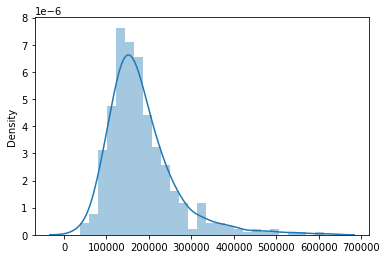

In [18]:
sns.distplot(y);
# skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 0.024255
Kurtosis: 1.078509


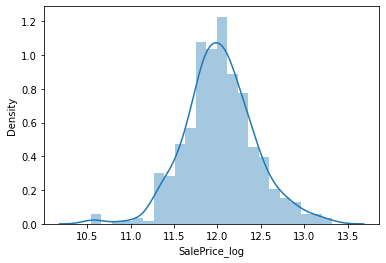

In [19]:
dataset.loc[:, 'SalePrice_log']  = np.log(y)

sns.distplot(dataset['SalePrice_log']);
# skewness and kurtosis
print("Skewness: %f" % dataset['SalePrice_log'].skew())
print("Kurtosis: %f" % dataset['SalePrice_log'].kurt())



# Features engineering

## Quantitative features regroupement

In [20]:
#Left cap excluded, right cap included
ListeDesReglesQuantiKB = { 
    'YrBltAndRemod': {
        1: [0,3917],
        2: [3918,3966],
        3: [3967,4010],
        4: [4011,8040]
    },
    'LotFrontage': {
        1: [0,60.0],
        2: [61.0,74.0],
        3: [75.0,90.0],
        4: [91.0,220.0]
    },
    'LotArea': {
        1: [0,8639],
        2: [8640,10990],
        3: [10991,13680],
        4: [13682,430490]
    },
    'YearBuilt': {
        1: [0,1956],
        2: [1957,1984],
        3: [1985,2005],
        4: [2006,4020]
    },
    'YearRemodAdd': {
        1: [0,1956],
        2: [1957,1983],
        3: [1984,2007],
        4: [2008,4020]
    },
    'BsmtFinSF2': {
        1: [0,80],
        2: [81,1029],
        3: [1031,1061],
        4: [1063,2948]
    },
    'GarageYrBlt': {
        1: [0,1958.0],
        2: [1959.0,1987.0],
        3: [1988.0,2005.0],
        4: [2006.0,4020.0]
    },
    'WoodDeckSF': {
        1: [0,84],
        2: [85,96],
        3: [97,158],
        4: [159,1714]
    },
    'OpenPorchSF': {
        1: [0,8],
        2: [10,29],
        3: [30,43],
        4: [44,1046]
    },
    'EnclosedPorch': {
        1: [0,36],
        2: [37,47],
        3: [48,140],
        4: [143,1104]
    },
}


## Categorical replacements

In [21]:
ListeDesReglesQuali = { 

    'HeatingQC': {
        1: ["Ex"],
        2: ["Gd","TA"],
        3: ["Fa","Po"]
    },
    'CentralAir': {
        1: ["Y"],
        2: ["N"]
    },
    'Electrical': {
        1: ["SBrkr"],
        2: ["FuseA","FuseF","FuseP"],
        3: ["Mix","eNA"] 
    },
    'BsmtFullBath': {
        1: ["0"],
        2: ["1"],
        3: ["2","3"]
    },
    'BsmtHalfBath': {
        1: ["0"],
        2: ["1","2"]
    },
    'FullBath': {
        1: ["0","1"],
        2: ["2","3","4"]
    },
    'HalfBath': {
        1: ["0"],
        2: ["1"],
        3: ["2"]
    },
    'BedroomAbvGr': {
        1: ["0","1","2"],
        2: ["3"],
        3: ["4"],
        4: ["5","6","7","8"]
    },
    'KitchenAbvGr': {
        1: ["0","1"],
        2: ["2","3"]
    },
    'KitchenQual': {
        1: ["Ex"],
        2: ["Fa","Po","TA"],
        3: ["Gd"]
    },
    'TotRmsAbvGrd': {
        1: ["2","3"],
        2: ["4"],
        3: ["5","6","7","8","9"],
        4: ["10","11","12","13","14","15"]
    },
    'Functional': {
        1: ["Typ","Mod"],
        2: ["Min1","Min2"],
        3:["Maj1","Maj2","Sev"]
    },
    'Fireplaces': {
        1: ["0"],
        2: ["1","2","3","4"]
    },
    'FireplaceQu': {
        1: ["Ex"],
        2: ["Gd"],
        3: ["TA"],
        4: ["Fa","Po","eNA"]
    },
    'GarageType': {
        1: ["Attchd"],
        2: ["BuiltIn"],
        3: ["2Types","Detchd"],
        4: ["Basment"],
        5: ["CarPort", "eNA"]
    },
    'GarageFinish': {
        1: ["RFn","Fin"],
        2: ["Unf"],
        3: ["eNA"]
    },
    
    'GarageCars': {
        1: ["0"],
        2: ["1"],
        3: ["2"],
        4: ["3","4","5"]
    },
    
    'GarageQual': {
        1: ["TA","Gd"],
        2: ["Ex"],
        3: ["Fa","eNA","Po"]
    },
    'GarageCond': {
        1: ["TA"],
        2:  ["Gd"],
        3:  ["Fa","eNA"],
        4:  ["Po"],
        5:  ["Ex"]
    },
    'PavedDrive': {
        1: ["Y"],
        2: ["N","P"]
    },
    'Fence': {
        1: ["eNA"],
        2: ["MnPrv","GdWo","MnWw"],
        3: ["GdPrv"]
    },
    #'MiscFeature': {
    #    1: ["eNA"],
    #    2: ["Shed","Gar2","Othr","TenC"]
    #},
    'MoSold': {
        1: ["1","3","4","5","6","8","9","10","11","12"],
        2: ["7"],
        3: ["2"]
    },
    'YrSold': {
        1: ["2006"],
        2: ["2007"],
        3: ["2008"],
        4: ["2009"],
        5: ["2010"]
    },
    'SaleType': {
        1: ["WD","COD","ConLw","ConLI","ConLD","Oth","CWD","VWD","Con"],
        2: ["New"]
    },
    'SaleCondition': {
        1: ["Normal"],
        2: ["Abnorml","AdjLand"],
        3: ["Alloca","Family","Partial"]
    },
    'MSSubClass': {
        1: ["20","60","120"],
        2: ["30","45","160","190","40","180","90","150"],
        3: ["50","70"],
        4: ["75","80","85"]
    },
    'RoofStyle': {
        1: ["Hip"],
        2: ["Gable","Gambrel","Mansard","Flat","Shed"]
    },
    'Exterior1st': {
        1: ["CemntBd","VinylSd","BrkFace"],
        2: ["MetalSd","Wd Sdng","HdBoard","Plywood","Stucco","WdShing","AsbShng"],
        3: ["BrkComm","AsphShn","ImStucc","CBlock","Stone"]
    },
    'Exterior2nd': {
        1: ["CmentBd","VinylSd","BrkFace","ImStucc","Stucco","Stone"],
        2: ["MetalSd","Wd Sdng","HdBoard","Plywood","AsbShng","AsphShn","Wd Shng"],
        3: ["Brk Cmn","CBlock","Other"]
    },
    'MasVnrType': {
        1: ["None", "BrkCmn", "eNA"],
        2: ["Stone", "BrkFace"]
    },
    'ExterQual': {
        1: ["Ex","Gd"],
        2: ["TA","Fa"]
    },
    'ExterCond': {
        1: ["Ex","Gd","TA"],
        2: ["Fa","Po"]
    },
    'Foundation': {
        1: ["PConc","Wood","Stone"],
        2: ["CBlock","BrkTil","Slab"]
    },
    'BsmtQual': {
        1: ["Ex"],
        2: ["Gd","TA"],
        3: ["Fa","eNA"]
    },
    'BsmtCond': {
        1: ["TA"],
        2: ["Gd"],
        3: ["Fa","Po","eNA"]
    },
    'BsmtExposure': {
        1: ["No","Mn","Av"],
        2: ["Gd"],
        3: ["eNA"]
    },
    'BsmtFinType1': {
        1: ["GLQ"],
        2: ["ALQ","Rec","BLQ","LwQ","Unf","eNA"]
    },
    'BsmtFinType2': {
        1: ["Unf"],
        2: ["Rec","BLQ","LwQ","eNA"],
        3: ["ALQ","GLQ"]
    },

    'MSZoning': {
        1: ["A","I","RP"],
        2: ["FV","RL"],
        3: ["C (all)","RH","RM"]
    },
    'Alley': {
        1: ["Grvl","Pave"],
        2: ["eNA"]
    },
    'LotShape': {
        1: ["Reg"],
        2: ["IR1","IR2","IR3"]
    },
    'LandContour': {
        1: ["Lvl"],
        2: ["Bnk","HLS","Low"]
    },
    'LotConfig': {
        1: ["Inside"],
        2: ["Corner","FR2"],
        3: ["CulDSac","FR3"]
    },
    'LandSlope': {
        1: ["Gtl"],
        2: ["Mod","Sev"]
    },
    'Condition1': {
        1: ["Artery","Feedr","RRAe","RRAn","RRNe"],
        2: ["Norm"],
        3: ["PosA","PosN","RRNn"]
    },
    'BldgType': {
        1: ["1Fam"],
        2: ["2fmCon","Duplex","Twnhs"],
        3: ["TwnhsE"]
    },
    'HouseStyle': {
        1: ["1.5Fin","1.5Unf","2.5Unf","SFoyer","SLvl"],
        2: ["1Story","2.5Fin","2Story"]
    },
    'OverallQual': {
        1: ["1","2","3","4"],
        2: ["5"],
        3: ["6"],
        4: ["7","8","9","10"]
    },
    
    'Neighborhood' : {
        1: ["NoRidge","NridgHt","StoneBr"],
        2: ["CollgCr","Veenker","Crawfor","Somerst","NWAmes","SawyerW","Timber","Gilbert","ClearCr","Blmngtn"],
        3: ["Mitchel","OldTown","BrkSide","Sawyer","NAmes","IDOTRR","MeadowV","Edwards","NPkVill","BrDale","SWISU","Blueste"]
    },    
    'OverallCond': {
        1: ["1","2","3","4"],
        2: ["5"],
        3: ["6","7","8","9"]
    }
   
}

In [22]:
# ----------- Pour chaque colonne du DataSet nous allons regrouper ------------
for feature in dataset:      
    # ------------------------ If the feature is categorical ----------------------    
    if (feature in ListeDesReglesQuali):
        featureDiscretise = ownLibrary.discretise_1col_quali(dataset[feature], feature, ListeDesReglesQuali[feature])
        dataset.drop([feature], axis=1, inplace=True)
        dataset[feature] = featureDiscretise

    # ------------------------ If the feature is continuous ----------------------                            
    elif (feature in ListeDesReglesQuantiKB):
        featureDiscretise = ownLibrary.discretise_1col_quanti(dataset[feature], feature, ListeDesReglesQuantiKB[feature])
        if( len(dataset[feature]) != len(featureDiscretise)):
            print('len(dataset[feature]) != len(featureDiscretise) : ' + str(dataset[feature]) + ' != ' + str(featureDiscretise))
        else:    
            dataset.drop([feature], axis=1, inplace=True)
            dataset[feature] = featureDiscretise          
                    

# Features regroupment

In [23]:
dataset["NewFirePlaces"] = dataset["Fireplaces"].astype(str) + dataset["FireplaceQu"].astype(str)
dataset["NewExterQualCond"] = dataset["ExterQual"].astype(str) + dataset["ExterCond"].astype(str)
dataset["NewCentrAirElec"] = dataset["CentralAir"].astype(str) + dataset["Electrical"].astype(str)
dataset["NewKitchen"] = dataset["KitchenAbvGr"].astype(str) + dataset["KitchenQual"].astype(str)
dataset["NewSale"] = dataset["SaleType"].astype(str) + dataset["SaleCondition"].astype(str)

dataset.drop(['Fireplaces'], axis=1, inplace=True)
dataset.drop(['FireplaceQu'], axis=1, inplace=True)
dataset.drop(['ExterQual'], axis=1, inplace=True)
dataset.drop(['ExterCond'], axis=1, inplace=True)
dataset.drop(['CentralAir'], axis=1, inplace=True)
dataset.drop(['Electrical'], axis=1, inplace=True)
dataset.drop(['KitchenAbvGr'], axis=1, inplace=True)
dataset.drop(['KitchenQual'], axis=1, inplace=True)
dataset.drop(['SaleType'], axis=1, inplace=True)
dataset.drop(['SaleCondition'], axis=1, inplace=True)

## Polynomial Transformation

In [24]:
pr2_best_performance = ['1stFlrSF','GarageArea']
pr3_best_performance = ['BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','GrLivArea']


In [25]:
dataset = ownLibrary.PolynomialRegrTransformationReturnDF(dataset, pr2_best_performance, 2)

['1stFlrSF²', '1stFlrSFGarageArea', 'GarageArea²']


In [26]:
dataset = ownLibrary.PolynomialRegrTransformationReturnDF(dataset, pr3_best_performance, 3)

['PR3_6', 'PR3_7', 'PR3_8', 'PR3_9', 'PR3_10', 'PR3_11', 'PR3_12', 'PR3_13', 'PR3_14', 'PR3_15', 'PR3_16', 'PR3_17', 'PR3_18', 'PR3_19', 'PR3_20', 'PR3_21', 'PR3_22', 'PR3_23', 'PR3_24', 'PR3_25', 'PR3_26', 'PR3_27', 'PR3_28', 'PR3_29', 'PR3_30', 'PR3_31', 'PR3_32', 'PR3_33', 'PR3_34', 'PR3_35', 'PR3_36', 'PR3_37', 'PR3_38', 'PR3_39', 'PR3_40', 'PR3_41', 'PR3_42', 'PR3_43', 'PR3_44', 'PR3_45', 'PR3_46', 'PR3_47', 'PR3_48', 'PR3_49', 'PR3_50', 'PR3_51', 'PR3_52', 'PR3_53', 'PR3_54', 'PR3_55']


## One-Hot encoding

In [27]:
ignore = ['Id','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','ScreenPorch','MiscVal','TotalSF','Total_sqr_footage','Total_Bathrooms','Total_porch_sf','haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace','SalePrice_log','SalePrice','1stFlrSF²','1stFlrSFGarageArea','GarageArea²','PR3_6','PR3_7','PR3_8','PR3_9','PR3_10','PR3_11','PR3_12','PR3_13','PR3_14','PR3_15','PR3_16','PR3_17','PR3_18','PR3_19','PR3_20','PR3_21','PR3_22','PR3_23','PR3_24','PR3_25','PR3_26','PR3_27','PR3_28','PR3_29','PR3_30','PR3_31','PR3_32','PR3_33','PR3_34','PR3_35','PR3_36','PR3_37','PR3_38','PR3_39','PR3_40','PR3_41','PR3_42','PR3_43','PR3_44','PR3_45','PR3_46','PR3_47','PR3_48','PR3_49','PR3_50','PR3_51','PR3_52','PR3_53','PR3_54','PR3_55']
dataset = ownLibrary.dichotomize_dataset(dataset, ignore)

# Modeling

In [28]:
target = 'SalePrice_log'

In [29]:
modelisation_feature = ['MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'ScreenPorch', 'TotalSF', 'Total_Bathrooms', 'hasgarage', 'hasfireplace', 'MSSubClass_1', 'MSSubClass_2', 'MSSubClass_3', 'MSZoning_2', 'LotFrontage_1', 'LotArea_2', 'Alley_1', 'LotShape_1', 'LandContour_1', 'LandSlope_1', 'Neighborhood_1', 'Neighborhood_2', 'Condition1_1', 'BldgType_2', 'BldgType_3', 'OverallQual_1', 'OverallQual_2', 'OverallQual_3', 'OverallCond_1', 'OverallCond_2', 'YearBuilt_2', 'YearBuilt_3', 'YearBuilt_4', 'YearRemodAdd_1', 'YearRemodAdd_4', 'RoofStyle_1', 'MasVnrType_1', 'Foundation_1', 'BsmtCond_1', 'BsmtCond_2', 'BsmtExposure_1', 'BsmtFinType2_2', 'BsmtFinType2_3', 'HeatingQC_1', 'HalfBath_1', 'BedroomAbvGr_3', 'BedroomAbvGr_4', 'TotRmsAbvGrd_3', 'TotRmsAbvGrd_4', 'Functional_1', 'Functional_2', 'GarageYrBlt_2', 'GarageCars_4', 'GarageCond_3', 'GarageCond_4', 'PavedDrive_1', 'WoodDeckSF_1', 'WoodDeckSF_3', 'EnclosedPorch_2', 'Fence_3', 'YrSold_1', 'YrSold_2', 'YrSold_4', 'YrBltAndRemod_1', 'YrBltAndRemod_4', 'NewExterQualCond_11', 'NewExterQualCond_21', 'NewCentrAirElec_11', 'NewCentrAirElec_12', 'NewKitchen_11', 'NewSale_11', 'NewSale_12', 'NewSale_13', '1stFlrSFGarageArea', 'PR3_9', 'PR3_11', 'PR3_21', 'PR3_24', 'PR3_31']

In [30]:
dataset

,Id,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,ScreenPorch,MiscVal,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,SalePrice_log,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSZoning_2,MSZoning_3,LotFrontage_1,LotFrontage_2,LotFrontage_3,LotFrontage_4,LotArea_1,LotArea_2,LotArea_3,LotArea_4,Alley_1,Alley_2,LotShape_1,LotShape_2,LandContour_1,LandContour_2,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Condition1_1,Condition1_2,Condition1_3,BldgType_1,BldgType_2,BldgType_3,HouseStyle_1,HouseStyle_2,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallCond_1,OverallCond_2,OverallCond_3,YearBuilt_1,YearBuilt_2,YearBuilt_3,YearBuilt_4,YearRemodAdd_1,YearRemodAdd_2,YearRemodAdd_3,YearRemodAdd_4,RoofStyle_1,RoofStyle_2,Exterior1st_1,Exterior1st_2,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,MasVnrType_1,MasVnrType_2,Foundation_1,Foundation_2,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinSF2_1,BsmtFinSF2_2,BsmtFinSF2_3,BsmtFinSF2_4,HeatingQC_1,HeatingQC_2,HeatingQC_3,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_1,FullBath_2,HalfBath_1,HalfBath_2,HalfBath_3,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,TotRmsAbvGrd_1,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,Functional_1,Functional_2,Functional_3,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageYrBlt_1,GarageYrBlt_2,GarageYrBlt_3,GarageYrBlt_4,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,GarageQual_1,GarageQual_2,GarageQual_3,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_1,PavedDrive_2,WoodDeckSF_1,WoodDeckSF_2,WoodDeckSF_3,WoodDeckSF_4,OpenPorchSF_1,OpenPorchSF_2,OpenPorchSF_3,OpenPorchSF_4,EnclosedPorch_1,EnclosedPorch_2,EnclosedPorch_3,EnclosedPorch_4,Fence_1,Fence_2,Fence_3,MoSold_1,MoSold_2,MoSold_3,YrSold_1,YrSold_2,YrSold_3,YrSold_4,YrSold_5,YrBltAndRemod_1,YrBltAndRemod_2,YrBltAndRemod_3,YrBltAndRemod_4,NewFirePlaces_14,NewFirePlaces_21,NewFirePlaces_22,NewFirePlaces_23,NewFirePlaces_24,NewExterQualCond_11,NewExterQualCond_21,NewExterQualCond_22,NewCentrAirElec_11,NewCentrAirElec_12,NewCentrAirElec_13,NewCentrAirElec_21,NewCentrAirElec_22,NewKitchen_11,NewKitchen_12,NewKitchen_13,NewKitchen_22,NewSale_11,NewSale_12,NewSale_13,NewSale_23,1stFlrSF²,1stFlrSFGarageArea,GarageArea²,PR3_6,PR3_7,PR3_8,PR3_9,PR3_10,PR3_11,PR3_12,PR3_13,PR3_14,PR3_15,PR3_16,PR3_17,PR3_18,PR3_19,PR3_20,PR3_21,PR3_22,PR3_23,PR3_24,PR3_25,PR3_26,PR3_27,PR3_28,PR3_29,PR3_30,PR3_31,PR3_32,PR3_33,PR3_34,PR3_35,PR3_36,PR3_37,PR3_38,PR3_39,PR3_40,PR3_41,PR3_42,PR3_43,PR3_44,PR3_45,PR3_46,PR3_47,PR3_48,PR3_49,PR3_50,PR3_51,PR3_52,PR3_53,PR3_54,PR3_55
0,1437,0.0,616,248,864,864,0,864,528,0,0,1728,1480,1.0,0,0,0,1,1,0,11.699405,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,746496.0,456192.0,278784.0,379456.0,152768.0,532224.0,0.0,532224.0,61504.0,214272.0,0.0,214272.0,746496.0,0.0,746496.0,0.0,0.0,746496.0,2.337449e+08,94105088.0,3.278500e+08,0.0,3.278500e+08,37886464.0,131991552.0,0.0,131991552.0,4.598415e+08,0.0,4.598415e+08,0.0,0.000000e+00,4.598415e+08,1.525299e+07,5.313946e+07,0.0,5.313946e+07,1.851310e+08,0.0,1.851310e+08,0.0,0.000000e+00,1.851310e+08,6.449725e+08,0.000000e+00,6.449725e+08,0.0,0.000000e+00,6.449725e+08,0.0,0.000000e+00,0.000000e+00,6.449725e+08
1,58,0.0,0,860,860,860,860,1720,565,0,0,2580,1720,2.5,70,0,1,1,1,0,12.188

In [31]:
from joblib import dump, load
model_deploy = load(cwd + "\\data\\testsavemodel.joblib") 

In [32]:
preds = pd.DataFrame()
preds = copy.deepcopy(dataset)
preds = preds.loc[:, ['Id', target]]
pred = model_deploy.predict(dataset[modelisation_feature])
preds['temp_lr'] = np.exp(pred.astype(float))
preds['pred_lr'] = preds['temp_lr'].clip(lower=0)
preds.drop(['temp_lr'], axis=1, inplace=True)

In [33]:
preds

,Id,SalePrice_log,pred_lr
0,1437,11.699405,118176.523407
1,58,12.188418,199302.065847
2,781,12.078239,174414.696727
3,383,12.271392,212825.207668
4,1171,12.049419,147999.148803
...,...,...,...
433,510,11.732061,141669.962163
434,556,11.635143,105875.937198
435,400,12.392552,207532.798409
436,546,12.341477,262013.775897


In [34]:
from sklearn.metrics import mean_squared_error, r2_score
print('------------- Modeling Result -------------')
print()

print('Train : ', end="")

print("R² = "+"{:.2%} ".format(r2_score(y, preds['pred_lr'])), end="")
print(', MSE = %.2f'
  % mean_squared_error(y, preds['pred_lr']))

------------- Modeling Result -------------

Train : R² = 91.54% , MSE = 544420003.48
